# ***AUDIO VISUALIZATION***

in questa parte diamo una rappresentazione delle caratteristiche audio (rappresentazione grafica degli spettrogrammi)

In [ ]:
!pip install praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

## Si importa il drive per i dati

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Si importa il dataset allineato

In [ ]:
!unzip "/content/drive/MyDrive/Final Data.zip"

Archive:  /content/drive/MyDrive/Final Data.zip
replace Final Data/191212/191212.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

Si sceglie un audio da rappresentare

In [ ]:
snd = parselmouth.Sound("/content/Final Data/120308/audios/120308_A3.mp3")

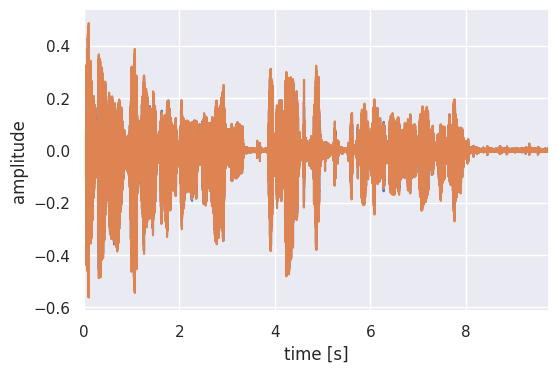

In [ ]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


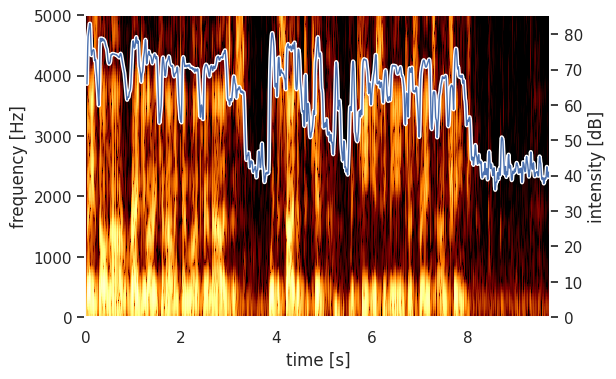

In [ ]:
intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

In [ ]:
pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

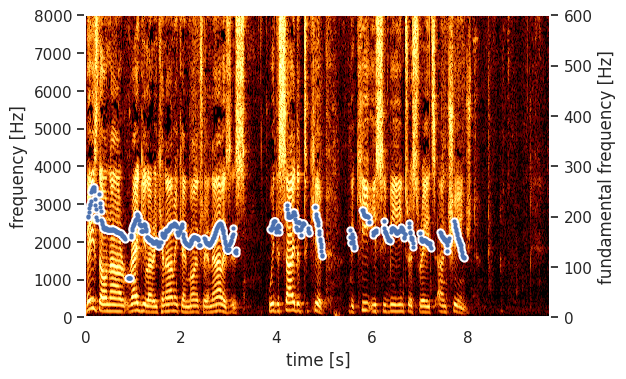

In [ ]:
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

CREATING THE MODEL ARCHITECTURE

- In Questa questa parte creiamo l'architettura per estrarre le caratteristiche degli audio --> Usiamo la contextual BilLSTM di Poria 2017



## We need to normalise the audio features now, before the ContextualBilLSTM



In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Input, Dense, GlobalMaxPooling1D, Masking, Dropout, TimeDistributed
from keras.models import Model
import tensorflow as tf

#After importing need packages we create the structure

input_data = Input(shape=(253,18,)) #here the imput are the audio file inside each folder. 253 is the longest number of audios (sentences), 18 is the number of features
lstm = Bidirectional(LSTM(5, activation='tanh', return_sequences = True, dropout=0.6))(input_data)
inter = Dropout(0.5)(lstm)
inter1 = TimeDistributed(Dense(9,activation='tanh'))(inter)
inter2 = GlobalMaxPooling1D()(inter1)
inter3 = Dense(1,activation = 'tanh')(inter2)
model = Model(input_data, inter3)
featred = Model(input_data,inter2)

In [ ]:
tf.random.set_seed(123)

In [ ]:
model.compile(loss='mse',optimizer='adam')

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 253, 18)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 253, 10)          960       
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 253, 10)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 253, 9)           99        
 tributed)                                                       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 9)                0         
 balMaxPooling1D)                                                
                                                           

In [ ]:
import pickle
with open('/content/drive/MyDrive/Thesis/audiodata.pkl', 'rb') as f:
  dx = pickle.load(f)


In [ ]:
import pickle
with open('/content/audiodata.pkl', 'wb') as f:
  pickle.dump(dx,f)

In [ ]:
#making a dictionary with format in which key=folder and values=contents of folders and then sorted it w.r.t keys  - ->  reason: for the final matrix it will be useful to find the tensors (required for fitting the model)
import re
from tqdm import tqdm
dy={}
for keys in tqdm(dx.keys()):
  temp = re.findall(r'\d+', keys)
  dy[temp[0]]=[]
  for k in dx.keys():
    if(keys[-15:-9]==k[-15:-9]):
      dy[temp[0]].append(k)
for key in dy.keys():
  dy[key]=sorted(dy[key])
dict(sorted(dy.items()))


100%|██████████| 24208/24208 [02:25<00:00, 165.83it/s]


{'111103': ['/content/Final Data/111103/audios/111103_A10.mp3',
  '/content/Final Data/111103/audios/111103_A11.mp3',
  '/content/Final Data/111103/audios/111103_A12.mp3',
  '/content/Final Data/111103/audios/111103_A13.mp3',
  '/content/Final Data/111103/audios/111103_A14.mp3',
  '/content/Final Data/111103/audios/111103_A15.mp3',
  '/content/Final Data/111103/audios/111103_A16.mp3',
  '/content/Final Data/111103/audios/111103_A17.mp3',
  '/content/Final Data/111103/audios/111103_A18.mp3',
  '/content/Final Data/111103/audios/111103_A19.mp3',
  '/content/Final Data/111103/audios/111103_A20.mp3',
  '/content/Final Data/111103/audios/111103_A21.mp3',
  '/content/Final Data/111103/audios/111103_A22.mp3',
  '/content/Final Data/111103/audios/111103_A23.mp3',
  '/content/Final Data/111103/audios/111103_A24.mp3',
  '/content/Final Data/111103/audios/111103_A25.mp3',
  '/content/Final Data/111103/audios/111103_A26.mp3',
  '/content/Final Data/111103/audios/111103_A27.mp3',
  '/content/Final 

In [ ]:
#selecting the 94 present in the STOXX50E dataset
import pandas as pd
import numpy as np
df = pd.read_csv("/content/STOXX50E.csv")
df
dz={}
for i in range(94):
  for key in dy.keys():
    if(str(df['date'][i])==key):
      dz[key]=dy[key]

In [ ]:
#this will be used later to select the 92 dates from text features
check=dz

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/STOXX50E.csv")
df
#finding the maximum number of files a folder has and then forming a list with the shape 92,variable,768 
#where variable=number of files in a folder
a=[]
max=0
for k in dz.keys():
  b=[]
  x=len(dz[k])
  if(x>max):
    max=x
    ind = k
  for i in range(len(dz[k])):
    b.append(np.asarray(dx[dz[k][i]]))
  a.append(b)
print(max)
#zero padding the list to make an array of shape 92,253,768
import numpy as np
for i in range(len(a)):
  dif = max - len(a[i])
  z = np.zeros((18))
  for j in range(dif):
    a[i].append(z)
a=np.asarray(a)
for i in range(94):
  df['STOXX50E'][i]=float(df['STOXX50E'][i].replace(',','.'))
import re

tempy=[]
xyz = []
#creating the regression value column tempyy for model fitting later on
for keys in dx.keys():
  temp = re.findall(r'\d+', keys)
  xyz.append(temp[0])
xyz = sorted(xyz)
k = set(xyz)
k = sorted(k)
k = list(k)
for j in range(len(k)):
  
  for i in range(len(list(df['date']))):
    
    if (str(k[j])==str(df['date'][i])):
      print(k[j],df['STOXX50E'][i])
      tempy.append(df['STOXX50E'][i])
tempy=np.asarray(tempy)
tempyy = np.reshape(tempy,(92,1))
tempyy.shape
#making sure every element in the array is an array
for i in range(92):
  for j in range(max):
    a[i][j] = np.asarray(a[i][j])

253
111103 -0.27
111208 -0.87
120112 -0.59
120209 -0.25
120308 -0.22
120404 -0.36
120503 -0.77
120705 -1.31
120802 -3.0
120906 0.86
121004 -0.26
121108 0.03
121206 0.08
130110 0.13
130207 0.28
130307 -0.11
130404 -0.72
130502 -0.3
130704 1.39
130801 0.1
130905 0.15
131002 -0.16
131107 -0.52
131205 -0.51
140109 -0.03
140206 -0.23
140306 -0.36
140403 0.98
140508 0.55
140605 0.51
140703 0.54
140807 -0.38
140904 0.55
141002 -1.45
141106 1.36
141204 -1.47
150122 0.24
150305 -0.12
150415 0.1
150603 -0.59
150716 -0.06
150903 0.89
151022 2.04
151203 -2.43
160121 -0.39
160310 -1.36
160421 -0.2
160602 -0.14
160721 0.23
160908 -0.37
161020 0.2
161208 0.36
170119 0.38
170309 0.43
170427 0.02
170608 -0.1
170720 -0.27
170907 0.04
171026 0.04
171214 0.36
180125 -0.59
180308 0.76
180426 -0.21
180614 0.61
180726 0.12
180913 -0.05
181025 -0.35
181213 -0.06
190124 -0.49
190307 -0.9
190410 0.11
190606 -0.27
190725 -1.48
190912 -0.45
191024 -0.1
191212 0.51
200123 -0.28
200312 -1.95
200430 -0.89
200604 -0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(tempy)

[-0.27 -0.87 -0.59 -0.25 -0.22 -0.36 -0.77 -1.31 -3.    0.86 -0.26  0.03
  0.08  0.13  0.28 -0.11 -0.72 -0.3   1.39  0.1   0.15 -0.16 -0.52 -0.51
 -0.03 -0.23 -0.36  0.98  0.55  0.51  0.54 -0.38  0.55 -1.45  1.36 -1.47
  0.24 -0.12  0.1  -0.59 -0.06  0.89  2.04 -2.43 -0.39 -1.36 -0.2  -0.14
  0.23 -0.37  0.2   0.36  0.38  0.43  0.02 -0.1  -0.27  0.04  0.04  0.36
 -0.59  0.76 -0.21  0.61  0.12 -0.05 -0.35 -0.06 -0.49 -0.9   0.11 -0.27
 -1.48 -0.45 -0.1   0.51 -0.28 -1.95 -0.89 -0.45  0.27  0.48  1.04 -0.67
 -0.14  0.03 -0.09  0.31 -0.3   0.16 -0.15 -0.47]


In [ ]:
a.shape

(92, 253, 18)

In [ ]:
a

array([[[1.78048012e+02, 2.90767295e+01, 1.23194919e+01, ...,
         1.50600000e+03, 3.50142283e-01, 6.90338441e+01],
        [1.91402792e+02, 3.16941105e+01, 1.06029969e+01, ...,
         1.05100000e+03, 4.32026809e-01, 7.05865994e+01],
        [1.80109469e+02, 2.44753469e+01, 1.29646068e+01, ...,
         2.37100000e+03, 3.62685195e-01, 7.03989307e+01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.72306511e+02, 2.70603492e+01, 1.42067486e+01, ...,
         2.39600000e+03, 3.06757474e-01, 6.58558080e+01],
        [1.72236077e+02, 3.20543629e+01, 1.29727477e+01, ...,
         1.12200000e+03, 4.75154788e-01, 6.53147924e+01],
        [1.76610312e+02, 

In [ ]:
ax=pd.DataFrame(a[91])
ax

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,184.503241,39.391868,10.744231,0.029209,0.000159,0.012925,0.014115,0.038774,0.101384,1.025384,0.037905,0.054918,0.106298,0.113714,858.0,831.0,0.364057,63.634186
1,188.277894,36.121095,11.924294,0.024732,0.000132,0.010397,0.013255,0.031192,0.088752,0.914945,0.032001,0.048040,0.086374,0.096002,1326.0,1292.0,0.382723,64.841892
2,157.151134,55.208403,10.004479,0.026691,0.000170,0.011803,0.013690,0.035408,0.099380,0.984209,0.036330,0.055308,0.094888,0.108989,2141.0,2050.0,0.491242,62.601681
3,237.043200,50.870592,9.933069,0.020324,0.000086,0.010195,0.011541,0.030585,0.109229,1.117866,0.043134,0.062814,0.111645,0.129402,588.0,576.0,0.372551,62.590134
4,218.313109,52.729486,12.241503,0.019592,0.000090,0.008721,0.009724,0.026162,0.108987,1.061141,0.041223,0.061134,0.108450,0.123668,4224.0,4099.0,0.451312,64.404907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


Normalizing the audio features

In [ ]:
for i in range(92):
  prenor=a[i]
  postnor=prenor
  postnor=(prenor-prenor.min())/(prenor.max()-prenor.min())
  a[i]=np.asarray(postnor)

In [ ]:
a.shape
a

array([[[6.59437083e-02, 1.07691591e-02, 4.56277477e-03, ...,
         5.57777778e-01, 1.29682327e-04, 2.55680904e-02],
        [7.08899229e-02, 1.17385594e-02, 3.92703588e-03, ...,
         3.89259259e-01, 1.60009929e-04, 2.61431850e-02],
        [6.67072106e-02, 9.06494331e-03, 4.80170623e-03, ...,
         8.78148148e-01, 1.34327850e-04, 2.60736781e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[4.13105995e-02, 6.48773655e-03, 3.40607734e-03, ...,
         5.74442580e-01, 7.35453067e-05, 1.57889734e-02],
        [4.12937129e-02, 7.68505463e-03, 3.11022482e-03, ...,
         2.69000240e-01, 1.13918674e-04, 1.56592645e-02],
        [4.23424387e-02, 

In [ ]:
#removing all the nan values
for i in range(92):
  for j in range(253):
    for k in range(18):
      if(np.isnan(a[i][j][k])):
        a[i][j][k]=0.0

In [ ]:
np.isnan(tempyy).any()

False

In [ ]:
#fitting the model
model.fit(a,tempyy,epochs=100,batch_size=10)

Epoch 1/100
10/10 [==============================] - 9s 16ms/step - loss: 0.5968
Epoch 2/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5746
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 0.5764
Epoch 4/100
10/10 [==============================] - 0s 17ms/step - loss: 0.5748
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5669
Epoch 6/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5718
Epoch 7/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5665
Epoch 8/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5396
Epoch 9/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5545
Epoch 10/100
10/10 [==============================] - 0s 17ms/step - loss: 0.5618
Epoch 11/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5511
Epoch 12/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5488
Epoch 13/100
10/10 [=====

In [ ]:
#extracting the features
audfeat2ndstage = featred.predict(a)

In [ ]:
audfeat2ndstage.shape

(92, 9)

In [ ]:
with open('/content/featuresaudio.pkl', 'wb') as f:
    pickle.dump(audfeat2ndstage, f)

# ***TEXT FEATURE EXTRACTION***

Here we are constructing the model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Input, Dense, GlobalMaxPooling1D, Masking, Dropout, TimeDistributed
from keras.models import Model
import tensorflow as tf
input_data = Input(shape=(253,768,))
#here the masking layer as in the last one, remember to change the name attraverso i layers
lstm = Bidirectional(LSTM(64, activation='tanh', return_sequences = True, dropout=0.6))(input_data)
inter = Dropout(0.5)(lstm)
inter1 = TimeDistributed(Dense(9,activation='tanh'))(inter)
inter2 = GlobalMaxPooling1D()(inter1)
inter3 = Dense(1,activation = 'tanh')(inter2)
model = Model(input_data, inter3)
featred = Model(input_data,inter2)

In [ ]:
#Custom Optimized Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Input, Dense, GlobalMaxPooling1D, Masking, Dropout, TimeDistributed
from keras.models import Model
import tensorflow as tf
input_data = Input(shape=(253,768,))
#here the masking layer as in the last one, remember to change the name attraverso i layers
lstm = Bidirectional(LSTM(768, activation='tanh', return_sequences = True, dropout=0.6))(input_data)
inter = Dropout(0.9)(lstm)
inter1 = TimeDistributed(Dense(18,activation='tanh'))(inter)
inter2 = GlobalMaxPooling1D()(inter1)
inter3 = Dense(1,activation = 'tanh')(inter2)
model = Model(input_data, inter3)
featred = Model(input_data,inter2)


In [ ]:
model.compile(loss='mse',optimizer='adam')

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 253, 768)]        0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 253, 128)         426496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 253, 128)          0         
                                                                 
 time_distributed_2 (TimeDis  (None, 253, 9)           1161      
 tributed)                                                       
                                                                 
 global_max_pooling1d_2 (Glo  (None, 9)                0         
 balMaxPooling1D)                                                
                                                           

# ***NEW***

We are reading the text features in this

In [ ]:
import pickle
with open('/content/drive/MyDrive/Thesis/textdata.pkl', 'rb') as f:
  dx = pickle.load(f)

In [ ]:
dx

Output hidden; open in https://colab.research.google.com to view.

We make a new dictionary with folder name as key and paths of its content as values

In [ ]:
import re
from tqdm import tqdm
dy={}
for keys in tqdm(dx.keys()):
  temp = re.findall(r'\d+', keys)
  dy[temp[0]]=[]
  for k in dx.keys():
    if(keys[-15:-9]==k[-15:-9]):
      dy[temp[0]].append(k)

 39%|███▉      | 9956/25360 [01:10<01:49, 140.69it/s]


KeyboardInterrupt: ignored

In [ ]:
for key in dy.keys():
  dy[key]=sorted(dy[key])

In [ ]:
dict(sorted(dy.items()))

In [ ]:
dy

In [ ]:
import pandas as pd
df = pd.read_csv("/content/STOXX50E.csv")
df

In [ ]:
dz={}
for i in range(94):
  for key in dy.keys():
    if(str(df['date'][i])==key):
      dz[key]=dy[key]

In [ ]:
dzz={}
for k in check.keys():
  for a in dz.keys():
    if(k==a):
      dzz[k]=dz[a]

In [ ]:
dzz

In [ ]:
a=[]
max=0
for k in dzz.keys():
  b=[]
  x=len(dzz[k])
  if(x>max):
    max=x
    ind = k
  for i in range(len(dzz[k])):
    b.append(dx[dzz[k][i]].numpy())
  a.append(b)

In [ ]:
ind

In [ ]:
max

In [ ]:
len(a[13])

In [ ]:
import numpy as np
for i in range(len(a)):
  dif = max - len(a[i])
  z = np.zeros((768))
  for j in range(dif):
    a[i].append(z)

In [ ]:
len(a)

In [ ]:
a=np.asarray(a)

In [ ]:
a.shape

In [ ]:
for i in range(94):
  df['STOXX50E'][i]=float(df['STOXX50E'][i].replace(',','.'))

In [ ]:
dzz

In [ ]:
import re
dy={}
tempy=[]
xyz = []
for key in dzz.keys():
  
  xyz.append(key)
xyz = sorted(xyz)
k = set(xyz)
k = sorted(k)
k = list(k)
for j in range(len(k)):
  
  for i in range(len(list(df['date']))):
    
    if (str(k[j])==str(df['date'][i])):
      print(k[j],df['STOXX50E'][i])
      tempy.append(df['STOXX50E'][i])
tempy=np.asarray(tempy)
tempyy = np.reshape(tempy,(92,1))
tempyy.shape

In [ ]:
tempy=np.asarray(tempy)
tempyy = np.reshape(tempy,(92,1))
tempyy.shape

In [ ]:
for i in range(92):
  for j in range(253):
    a[i][j] = np.asarray(a[i][j])

In [ ]:
for i in range(92):
  prenor=a[i]
  postnor=prenor
  postnor=(prenor-prenor.min())/(prenor.max()-prenor.min())
  a[i]=np.asarray(postnor)


In [ ]:
print(np.isnan(a))
print(np.any(np.isnan(a)))

In [ ]:
model.fit(a,tempyy,epochs=100,batch_size=10)

In [ ]:
textfeat2ndstage = featred.predict(a)

In [ ]:
textfeat2ndstage.shape

In [ ]:
with open('/content/featurestext.pkl', 'wb') as f:
    pickle.dump(textfeat2ndstage, f)

# ***Final Model***

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Input, Dense, GlobalMaxPooling1D, Masking, Dropout, TimeDistributed
from keras.models import Model
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import math as m

In [ ]:
with open("/content/featuresaudio.pkl","rb") as f: aud = pickle.load(f)
with open("/content/featurestext.pkl","rb") as f: text = pickle.load(f)

In [ ]:
aud.shape

In [ ]:
data = np.concatenate((aud,text),axis=1)
data.shape

In [ ]:
data = np.reshape(data,(92,1,18))

In [ ]:
def elliptic_paraboloid_loss(x, y, c_diff_sign = 1, c_same_sign = 1):

    t = tf.constant(np.pi / 4)

    x_rot = (x * tf.math.cos(t)) + (y * tf.math.sin(t))

    y_rot = (x * -tf.math.sin(t)) + (y * tf.math.cos(t))

    z = ((tf.math.pow(x_rot,2)) / c_diff_sign) + (tf.math.pow(y_rot,2) / c_same_sign)

    return z*sqrt(abs(x*x-y*y))

In [ ]:
input_data = Input(shape=(1,18,))
#masked = Masking(mask_value =0)(input_data)
lstm = Bidirectional(LSTM(18, activation='tanh', return_sequences = True, dropout=0.9))(input_data)
drop = Dropout(0.9)(lstm)
gmp = GlobalMaxPooling1D()(drop)
fc1 = Dense(16,activation='tanh')(gmp)
drop2 = Dropout(0.9)(fc1)
fc2 = Dense(8,activation='tanh')(drop2)
fc3 = Dense(4,activation='tanh')(fc2)
drop3 = Dropout(0.9)(fc3)
fc4 = Dense(4,activation='tanh')(drop3)
fc5 = Dense(2,activation='tanh')(fc4)
fc6 = Dense(2,activation='tanh')(fc5)
inter3 = Dense(1,activation = 'tanh')(fc6)

model = Model(input_data, inter3)
#featred = Model(input_data,gmp)

In [ ]:
model.compile(loss='mse',optimizer='rmsprop',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

In [ ]:
data


In [ ]:
import matplotlib.pyplot as plt


def show_pred(y,pred):
  plt.plot(list(y),label='actual')
  plt.plot(list(pred),label='predicted')
  plt.title("actual vs predictions")
  plt.legend()
  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
X = data

In [ ]:
X_,X_test,y_,y_test = train_test_split(data,tempyy,test_size=0.1,shuffle=False)
X_train,X_val,y_train,y_val = train_test_split(X_,y_,test_size=0.1,shuffle=False)

In [ ]:
history = model.fit(X_train,y_train,epochs=100,validation_data = (X_val,y_val),batch_size=4)

In [ ]:
import matplotlib.pyplot as plt



# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
dl_pred = model.predict(X_test)

In [ ]:
np.sqrt(mse(y_test,dl_pred))

In [ ]:
show_pred(y_test,dl_pred)

In [ ]:
datax = np.reshape(data,(92,18))

In [ ]:
X_t,X_ts,y_t,y_ts = train_test_split(datax,tempyy,test_size=0.05,shuffle=False)

In [ ]:
X_t.shape

# ***Light GBM***

In [ ]:
import lightgbm as lgb

In [ ]:
clf = lgb.LGBMRegressor(n_estimators=1000)

In [ ]:
clf.fit(X_t,y_t)

In [ ]:
lgb_pred = clf.predict(X_ts)

In [ ]:
show_pred(y_ts,lgb_pred)

In [ ]:
np.sqrt(mse(y_ts,lgb_pred))

# ***XGBoost Regressor***

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor()

In [ ]:
model.fit(X_t,y_t)

In [ ]:
xgb_pred = model.predict(X_ts)

In [ ]:
show_pred(y_ts,xgb_pred)

# ***RandomForest Regressor***

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfc = RandomForestRegressor()

In [ ]:
rfc.fit(X_t,y_t)

In [ ]:
rfc_pred = rfc.predict(X_ts)

In [ ]:
np.sqrt(mse(y_ts,rfc_pred))

In [ ]:
show_pred(y_ts,rfc_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['squared_error', 'absolute_error']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_t, y_t)


In [ ]:
CV_rfc.best_params_

In [ ]:
rfc1 = RandomForestRegressor(criterion='squared_error',max_depth=4,max_features='sqrt',n_estimators=1000)

In [ ]:
rfc1.fit(X_t,y_t)

In [ ]:
predx = rfc1.predict(X_ts)

In [ ]:
np.sqrt(mse(y_ts,predx))

In [ ]:
show_pred(y_ts,predx)

# ***Model stacking***

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

In [ ]:
from lightgbm.sklearn import LGBMRegressor
def get_stacking():
	# define the base models
	level0 = list()
	# level0.append(('knn', KNeighborsRegressor()))
	# level0.append(('cart', DecisionTreeRegressor()))
	# level0.append(('svm', SVR()))

	level0.append(('lgb', LGBMRegressor()))
	level0.append(('rfc', RandomForestRegressor()))
	level0.append(('xbg', XGBRegressor()))


	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model

In [ ]:
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['lgb'] = LGBMRegressor()
	models['rfc'] = RandomForestRegressor()
	models['xgb'] = XGBRegressor()

	models['stacking'] = get_stacking()
	return models


In [ ]:
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [ ]:
mdl = get_stacking()
mdl.fit(X_t,y_t).score(X_ts,y_ts)


In [ ]:
preds = mdl.predict(X_ts)
preds

In [ ]:
np.sqrt(mse(y_ts,preds))

In [ ]:
show_pred(y_ts,preds)

In [ ]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, datax, tempyy)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))